# Analyzing the World Series Games

- batters
- pitchers
- inning by inning

In [10]:
#grab data
import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import *

ws_df = pd.read_csv('../cleaned/pitch_by_pitch.csv')
games_df = pd.read_csv('../cleaned/games.csv')
batters_df = pd.read_csv('../cleaned/batters.csv')
pitchers_df = pd.read_csv('../cleaned/pitchers.csv')
con = duckdb.connect()

ws_df = con.sql("""
    SELECT *,  game_pk AS game_id,
    CASE
        WHEN game_type = 'W' THEN 'World Series'
        WHEN game_type = 'E' THEN 'Exhibition'
        WHEN game_type = 'S' THEN 'Spring Training'
        WHEN game_type = 'R' THEN 'Regular Season'
        WHEN game_type = 'F' THEN 'Wild Card'
        WHEN game_type = 'D' THEN 'Divisional Series'
        WHEN game_type = 'L' THEN 'League Championship Series'
    END AS game_name
    FROM ws_df
    WHERE game_name = 'World Series'
    ORDER BY game_date
        """).to_df()

ws_df = ws_df.drop(columns=["game_type"])
ws_df.columns

Index(['game_date', 'pitcher', 'batter', 'balls', 'strikes', 'inning',
       'inning_topbot', 'at_bat_number', 'pitch_number', 'events',
       'pitch_type', 'pitch_name', 'release_speed', 'release_pos_x',
       'release_pos_z', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'stand', 'p_throws', 'type', 'hit_location', 'bb_type', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
       'fielder_2', 'fielder_2.1', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed',
       'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'game_pk', 'fielder_2.2', 'fielder_2.3',
       'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7',
       'fielder_8', 'fielder_9', 'release_pos_y',
       'estimated

# CHECK OUT THE DATA

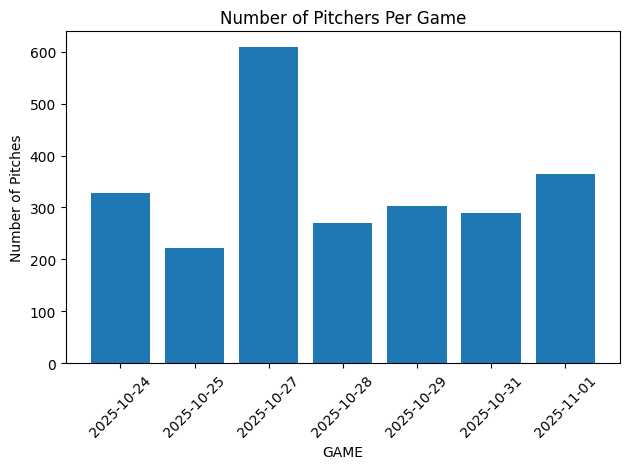

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

#how many pitches per game
pitches_per_game = con.sql("""
        SELECT count(*) as num_pitches, game_id, game_date
        FROM ws_df
        GROUP BY game_id, game_date
        ORDER BY game_date ASC;
        """).to_df()

pitches_per_game

plt.bar(pitches_per_game['game_date'], pitches_per_game['num_pitches'])
plt.xlabel('GAME')
plt.ylabel('Number of Pitches')
plt.title('Number of Pitchers Per Game')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

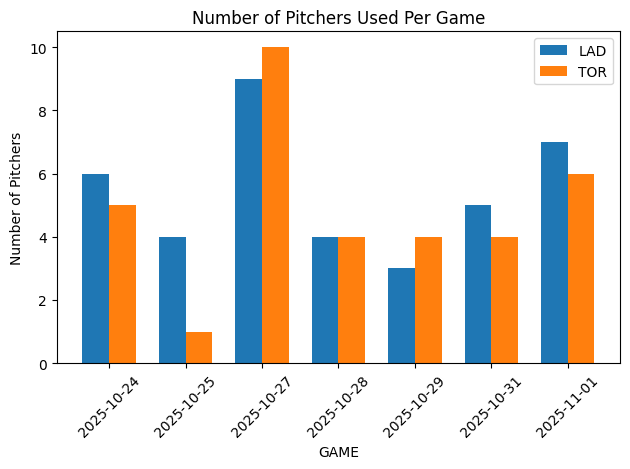

In [ ]:
#how many pitchers were used by game by team?
pitchers_per_team = con.sql("""
    SELECT g.game_id, g.game_date,
        CASE 
            WHEN w.inning_topbot = 'Top' THEN g.away_team
            WHEN w.inning_topbot = 'Bot' THEN g.home_team
        END AS pitching_team, count(distinct w.pitcher) AS num_pitchers
    FROM ws_df AS w
    JOIN games_df AS g ON w.game_id = g.game_id
    GROUP BY g.game_id, g.game_date, g.home_team, g.away_team, pitching_team
    ORDER BY g.game_date ASC,
        CASE 
            WHEN pitching_team = g.home_team THEN 0
            ELSE 1
        END;
""").to_df()


game_dates = pitchers_per_team['game_date'].unique()
x = np.arange(len(game_dates)) 
width = 0.35 
home_pitchers = pitchers_per_team[pitchers_per_team['pitching_team'] == 
                                  pitchers_per_team['pitching_team'].map(lambda t: t if t in pitchers_per_team['pitching_team'].values else None)]
away_pitchers = pitchers_per_team[pitchers_per_team['pitching_team'] != 
                                  pitchers_per_team['pitching_team'].map(lambda t: t if t in pitchers_per_team['pitching_team'].values else None)]


pivot_df = pitchers_per_team.pivot(index='game_date', columns='pitching_team', values='num_pitchers').fillna(0)
plt.bar(x - width/2, pivot_df[pivot_df.columns[0]], width, label=pivot_df.columns[0])
plt.bar(x + width/2, pivot_df[pivot_df.columns[1]], width, label=pivot_df.columns[1])
plt.xlabel('GAME')
plt.ylabel('Number of Pitchers')
plt.title('Number of Pitchers Used Per Game')
plt.xticks(x, pivot_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# avg pitches per batter over the course of the games they played in
pitches_batter = con.sql("""
    WITH pitches_batter AS (SELECT batter, count(*) as num_pitches
    FROM ws_df
    GROUP BY batter),
    games_per_batter AS (SELECT batter, count(distinct(game_id)) as num_appearances
    FROM ws_df
    GROUP BY batter)
        SELECT p.batter, p.num_pitches / g.num_appearances as avg_pitches_seen
        FROM pitches_batter p
        JOIN games_per_batter g on p.batter = g.batter
        ORDER BY avg_pitches_seen DESC;
""").to_df()

pitches_batter.merge(batters_df, left_on = 'batter', right_on = 'batter_id', how = 'left').drop(columns = ['batter_id'])

,batter,avg_pitches_seen,full_name,team_name
0,665489,21.285714,"guerrero, vladimir",TOR
1,605141,20.714286,"betts, mookie",LAD
2,662139,20.142857,"varsho, daulton",TOR
3,518692,19.571429,"freeman, freddie",LAD
4,669257,19.000000,"smith, will",LAD
5,665926,18.571429,"giménez, andrés",TOR
6,606192,18.571429,"hernández, teoscar",LAD
7,571970,18.285714,"muncy, max",LAD
8,672386,18.000000,"kirk, alejandro",TOR
9,660271,17.571429,"ohtani, shohei",LAD


In [14]:
# avg pitchers per pitcher for games pitched
pitches_pitcher = con.sql("""
    WITH pitches_pitcher AS (SELECT pitcher, count(*) as num_pitches
    FROM ws_df
    GROUP BY pitcher),
    games_per_pitcher AS (SELECT pitcher, count(distinct(game_id)) as num_appearances
    FROM ws_df
    GROUP BY pitcher)
        SELECT p.pitcher, p.num_pitches / g.num_appearances as avg_pitches_thrown
        FROM pitches_pitcher p
        JOIN games_per_pitcher g on p.pitcher = g.pitcher
        ORDER BY avg_pitches_thrown DESC;
""").to_df()

pitches_pitcher.merge(pitchers_df, left_on = 'pitcher', right_on = 'pitcher_id', how = 'left').drop(columns = ['pitcher_id'])

,pitcher,avg_pitches_thrown,full_name,team_name
0,592332,87.500000,"gausman, kevin",TOR
1,605483,81.333333,"snell, blake",LAD
2,808967,78.333333,"yamamoto, yoshinobu",LAD
3,660271,72.000000,"ohtani, shohei",LAD
4,702056,68.333333,"yesavage, trey",TOR
5,453286,66.500000,"scherzer, max",TOR
6,669456,47.000000,"bieber, shane",TOR
7,694361,43.000000,"klein, will",LAD
8,641778,42.500000,"lauer, eric",TOR
9,607192,42.000000,"glasnow, tyler",LAD


In [15]:
# avg batters per pitcher
batters_pitcher = con.sql("""
    WITH batters_pitcher AS (SELECT pitcher, count(distinct game_id || '-' || at_bat_number) as num_batters
    FROM ws_df
    GROUP BY pitcher),
    games_per_pitcher AS (SELECT pitcher, count(distinct(game_id)) as num_appearances
    FROM ws_df
    GROUP BY pitcher)
        SELECT p.pitcher, p.num_batters / g.num_appearances as avg_batters_game
        FROM batters_pitcher p
        JOIN games_per_pitcher g on p.pitcher = g.pitcher
        ORDER BY avg_batters_game DESC;
""").to_df()

batters_pitcher.merge(pitchers_df, left_on = 'pitcher', right_on = 'pitcher_id', how = 'left').drop(columns = ['pitcher_id'])

,pitcher,avg_batters_game,full_name,team_name
0,592332,23.000000,"gausman, kevin",TOR
1,808967,21.666667,"yamamoto, yoshinobu",LAD
2,605483,19.666667,"snell, blake",LAD
3,660271,19.000000,"ohtani, shohei",LAD
4,453286,18.000000,"scherzer, max",TOR
5,702056,16.000000,"yesavage, trey",TOR
6,669456,13.500000,"bieber, shane",TOR
7,607192,11.333333,"glasnow, tyler",LAD
8,641778,10.500000,"lauer, eric",TOR
9,694361,9.500000,"klein, will",LAD


# Batter data

┌────────────┬────────────────────┐
│ pitch_type │     pitch_name     │
│  varchar   │      varchar       │
├────────────┼────────────────────┤
│ CH         │ Change-up          │
│ CU         │ Curveball          │
│ FC         │ Cutter             │
│ FF         │ Four-Seam Fastball │
│ FS         │ Splitter           │
│ KC         │ Knuckle Curve      │
│ SI         │ Sinker             │
│ SL         │ Slider             │
│ ST         │ Sweeper            │
└────────────┴────────────────────┘



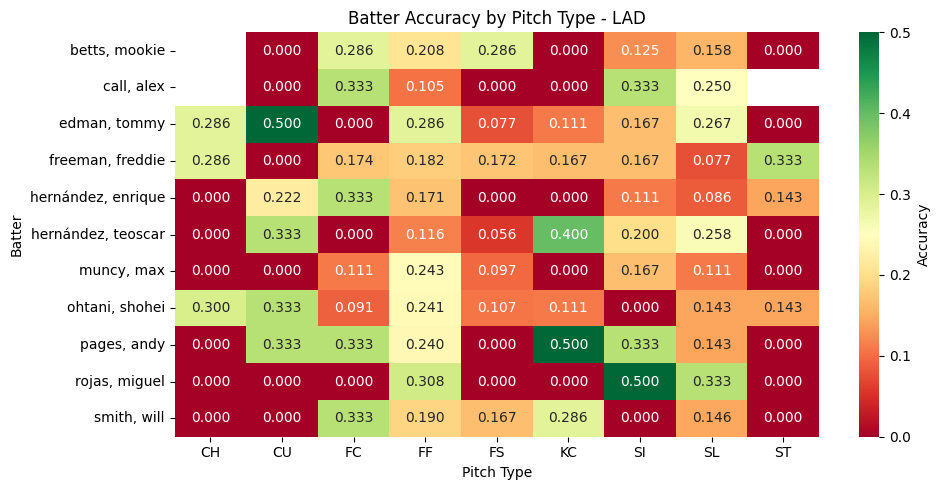

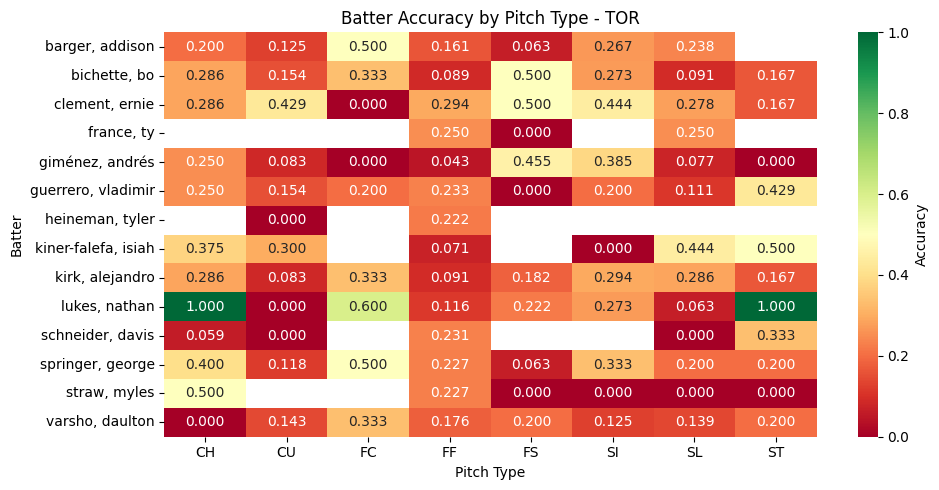

In [51]:
# batter accuracy on type of pitch

# output variables: batting_average (on pitch type)
ba_pitch_type = con.sql("""
        SELECT
            batter,
            pitch_type,
            COUNT(*) as num_pitches_seen,
            SUM(CASE WHEN events IN ('single','double','triple','home_run') OR description = 'hit_into_play' THEN 1 ELSE 0 END) as num_hits,
            SUM(CASE WHEN description IN ('called_strike') THEN 1 ELSE 0 END) as strike_watching,
            SUM(CASE WHEN description IN ('foul', 'strike_swinging') THEN 1 ELSE 0 END) as strike_swinging,
            ROUND(SUM(CASE WHEN events IN ('single','double','triple','home_run') OR description = 'hit_into_play' THEN 1 ELSE 0 END) * 1.0 / COUNT(*), 3) AS accuracy
        FROM ws_df
        GROUP BY batter, pitch_type
        ORDER BY batter, pitch_type;
        """).to_df()

batter_data = ba_pitch_type.merge(batters_df, left_on = 'batter', right_on = 'batter_id', how = 'left').drop(columns = ['batter_id'])

#print out legend (names of the variables)
print(con.sql("""
    SELECT DISTINCT
        pitch_type,
        CASE 
            WHEN pitch_type = 'AB' THEN 'Automatic Ball'
            WHEN pitch_type = 'AS' THEN 'Automatic Strike'
            WHEN pitch_type = 'CH' THEN 'Change-up'
            WHEN pitch_type = 'CU' THEN 'Curveball'
            WHEN pitch_type = 'EP' THEN 'Eephus'
            WHEN pitch_type = 'FC' THEN 'Cutter'
            WHEN pitch_type = 'FF' THEN 'Four-Seam Fastball'
            WHEN pitch_type = 'FO' THEN 'Forkball'
            WHEN pitch_type = 'FS' THEN 'Splitter'
            WHEN pitch_type = 'FT' THEN 'Two-Seam Fastball'
            WHEN pitch_type = 'GY' THEN 'Gyroball'
            WHEN pitch_type = 'IN' THEN 'Intentional Ball'
            WHEN pitch_type = 'KC' THEN 'Knuckle Curve'
            WHEN pitch_type = 'KN' THEN 'Knuckleball'
            WHEN pitch_type = 'NP' THEN 'No Pitch'
            WHEN pitch_type = 'PO' THEN 'Pitchout'
            WHEN pitch_type = 'SC' THEN 'Screwball'
            WHEN pitch_type = 'SI' THEN 'Sinker'
            WHEN pitch_type = 'SL' THEN 'Slider'
            WHEN pitch_type = 'ST' THEN 'Sweeper'
            ELSE 'Unknown'
        END AS pitch_name
    FROM ws_df
    ORDER BY pitch_type
"""))

# do some visualizations on batter_data
teams = batter_data['team_name'].unique()

for team in teams:
    df_team = batter_data[batter_data['team_name'] == team]
    heatmap_data = df_team.pivot(index='full_name', columns='pitch_type', values='accuracy')
    
    plt.figure(figsize=(10, 5)) 
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='RdYlGn', cbar_kws={'label':'Accuracy'})
    plt.title(f'Batter Accuracy by Pitch Type - {team}')
    plt.xlabel('Pitch Type')
    plt.ylabel('Batter')
    plt.tight_layout()
    plt.show()


# Pitcher data

In [8]:
# pitcher performance on each handed batters

# MORE QUESTIONS THAT I WILL BE ADDING
- Which pitchers struggled with different sided batters
- What batters performed the best
- What batters struggled with what pitches
- What batters performed best on what pitches
- What pitches overall were the best to throw
- Performance overall of the games
- Avg pitches per batter
- Avg pitches per pitcher
- etc.

# What you can derive by my data analysis

- going to finish data first